In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import sys
from matplotlib import animation, rc
from IPython.display import HTML, Image
import pandas as pd

src_dir = os.path.abspath("/home/mmfarrugia/repos/optimization/hybrid_optimizer")
sys.path.append(src_dir)

from hybrid_optimizer import PSO_DE
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters.plotters import plot_cost_history, plot_contour
from plotters import plot_summary, plot_surface
import example_funcs

technical_replicates = 10
size_pop = 50
max_iter = 200

In [2]:
# Universal config setup
random_config = {
    'name': 'Random',
    "n_dim": 2,
    "size_pop": size_pop,
    "vectorize_func": False,
    "taper_DE": False,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/rand/1'
}
random_fixedF_config = {
    'name': 'RandomFixedF',
    "n_dim": 2,
    "size_pop": size_pop,
    "vectorize_func": False,
    "F": (0.5, 0.5),
    "taper_DE": False,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/rand/1'
}
best_config = {
    'name': 'Best',
    "n_dim": 2,
    "size_pop": size_pop,
    "vectorize_func": False,
    "taper_DE": False,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/best/1'
}
best_fixedF_config = {
    'name': 'BestFixedF',
    "n_dim": 2,
    "F": (0.5, 0.5),
    "size_pop": size_pop,
    "vectorize_func": False,
    "taper_DE": False,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/best/1'
}

taper_rand_config = {
    'name': 'RandTaperFreq',
    "n_dim": 2,
    "size_pop": size_pop,
    "vectorize_func": False,
    "taper_DE": True,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/rand/1'
}

taper_best_config = {
    'name': 'BestTaperFreq',
    "n_dim": 2,
    "size_pop": size_pop,
    "vectorize_func": False,
    "taper_DE": True,
    "max_iter": max_iter,
    "guess_deviation":0,
    "guess_ratio":1.0,
    "mutation_strategy": 'DE/best/1'
}

configs = [random_config, random_fixedF_config, best_config, best_fixedF_config, taper_rand_config, taper_best_config]

In [3]:
def run_plot_opts(function, dimensions, config_list, technical_replicates, name):
    fig, ax = plt.subplots(1, len(config_list), figsize=(5.5*len(config_list),6), sharey=True)
    fig.suptitle(name)
    opts = {}
    full_opts = {}
    for i, config in enumerate(config_list):
        opt_name = config['name']
        full_opts[opt_name] = []
        opt = (PSO_DE(function, n_dim=dimensions, config=config))
        opt.record_mode = True
        opt.run()
        print('i: best_x is ', opt.gbest_x, 'best_y is', opt.gbest_y)
        opts[opt_name] = opt
        full_opts[opt_name].append(opt)
        sum_loss = np.array(opt.gbest_y_hist)
        sum_x = np.array(opt.gbest_x)
        sum_y = opt.gbest_y
        for t in range(technical_replicates-1):
            opt = (PSO_DE(function, n_dim=dimensions, config=config))
            opt.record_mode = True
            opt.run()
            full_opts[opt_name].append(opt)
            sum_loss += opt.gbest_y_hist
            sum_x += opt.gbest_x
            sum_y += opt.gbest_y
        #fig.add_subplot(1, len(configs), i+1)
        average_loss = np.divide(sum_loss, technical_replicates)
        average_x = np.divide(sum_x, technical_replicates)
        average_y = sum_y / technical_replicates
        #average_x = ["{:.5e}".format(x) for x in average_x]
        results_text =  "{:.5e}".format(average_y[0]) + ' @ X: ' + str(average_x)
        ax[i].plot(average_loss)
        #plt.xlabel('Iteration')
        ax[i].set_ylabel('Best Known F(X)')
        ax[i].annotate(results_text, (0,0), (0,-20), xycoords='axes fraction', textcoords='offset points', va='top')
        ax[i].set_title(opt_name)

    fig.tight_layout()
    plt.show()

    return opts, full_opts

In [4]:
def plot_swarm_w_loss(opts, config_list, title="Swarm Diversity & Loss"):
    Y_history = []
    fig, ax = plt.subplots(2, len(opts), figsize=(5*len(config_list),8), sharey='row')
    fig.suptitle(title)
    for i, key in enumerate(opts):
        opt = opts[key]
        Y_history = pd.DataFrame(np.array(opt.record_value['Y']).reshape((-1, opt.size_pop)))
        ax[0,i].plot(Y_history.index, Y_history.values, '.')
        ax[0,i].set_title(config_list[i]['name'])
        Y_history.min(axis=1).cummin().plot(kind='line', ax=ax[1,i])
        print(len(Y_history))
    plt.show()

Himmelblau's  objective function

    Only takes two dimensions and has a four equal global minimums
     of zero at :code:`f([3.0,2.0])`, :code:`f([-2.805118,3.131312])`,
     :code:`f([-3.779310,-3.283186])`, and :code:`f([3.584428,-1.848126])`.
    Its coordinates are bounded within :code:`[-5,5]`.

    Best visualized with the full domain and a range of :code:`[0,1000]`

In [ ]:
import copy
n_dim = 2
lb = [-3.1, -5.]
ub = [3.1, 5.]
size_pop = 50
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

global_opt = [3., 2., 0.]

for config in configs:
    config["initial_guesses"] = common_start
    config["lb"] = lb
    config["ub"] = ub
    config["n_dim"] = n_dim
    config["vectorize_func"] = False

In [ ]:
#Plot the sphere function's mesh for better plots
m = Mesher(func=example_funcs.himmelblau, limits=[(-3.1,3.1), (-5,5)])
#Adjust figure limits
d = Designer(limits=[(-5,5), (-5,5), (0,1000)], label=['x-axis', 'y-axis', 'z-axis'])

i: best_x is  [ 3.58104386 -1.86013246] best_y is [0.00300682]
i: best_x is  [-2.79685508  3.13358184] best_y is [0.0024431]
i: best_x is  [2.99998488 1.99995014] best_y is [6.57912849e-08]
i: best_x is  [2.99999218 2.00014593] best_y is [3.41459732e-07]
i: best_x is  [2.99999998 2.00000001] best_y is [8.68904302e-15]
i: best_x is  [2.99999999 1.99999998] best_y is [7.85627879e-15]


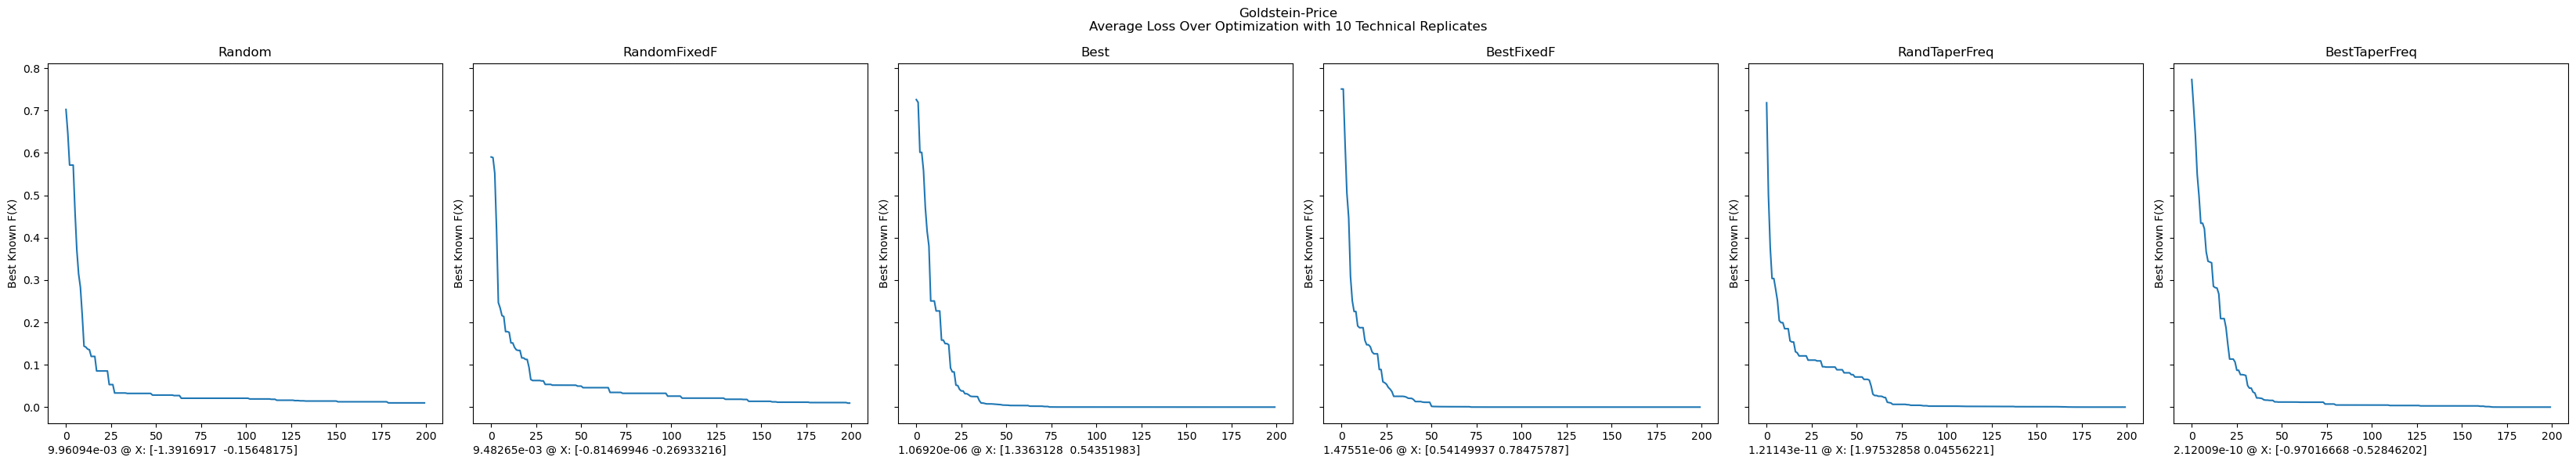

In [7]:
opts, full_opts = run_plot_opts(example_funcs.himmelblau, n_dim, configs, technical_replicates, 'Goldstein-Price\nAverage Loss Over Optimization with '+ str(technical_replicates) + ' Technical Replicates')

400
400
400
400
261
261


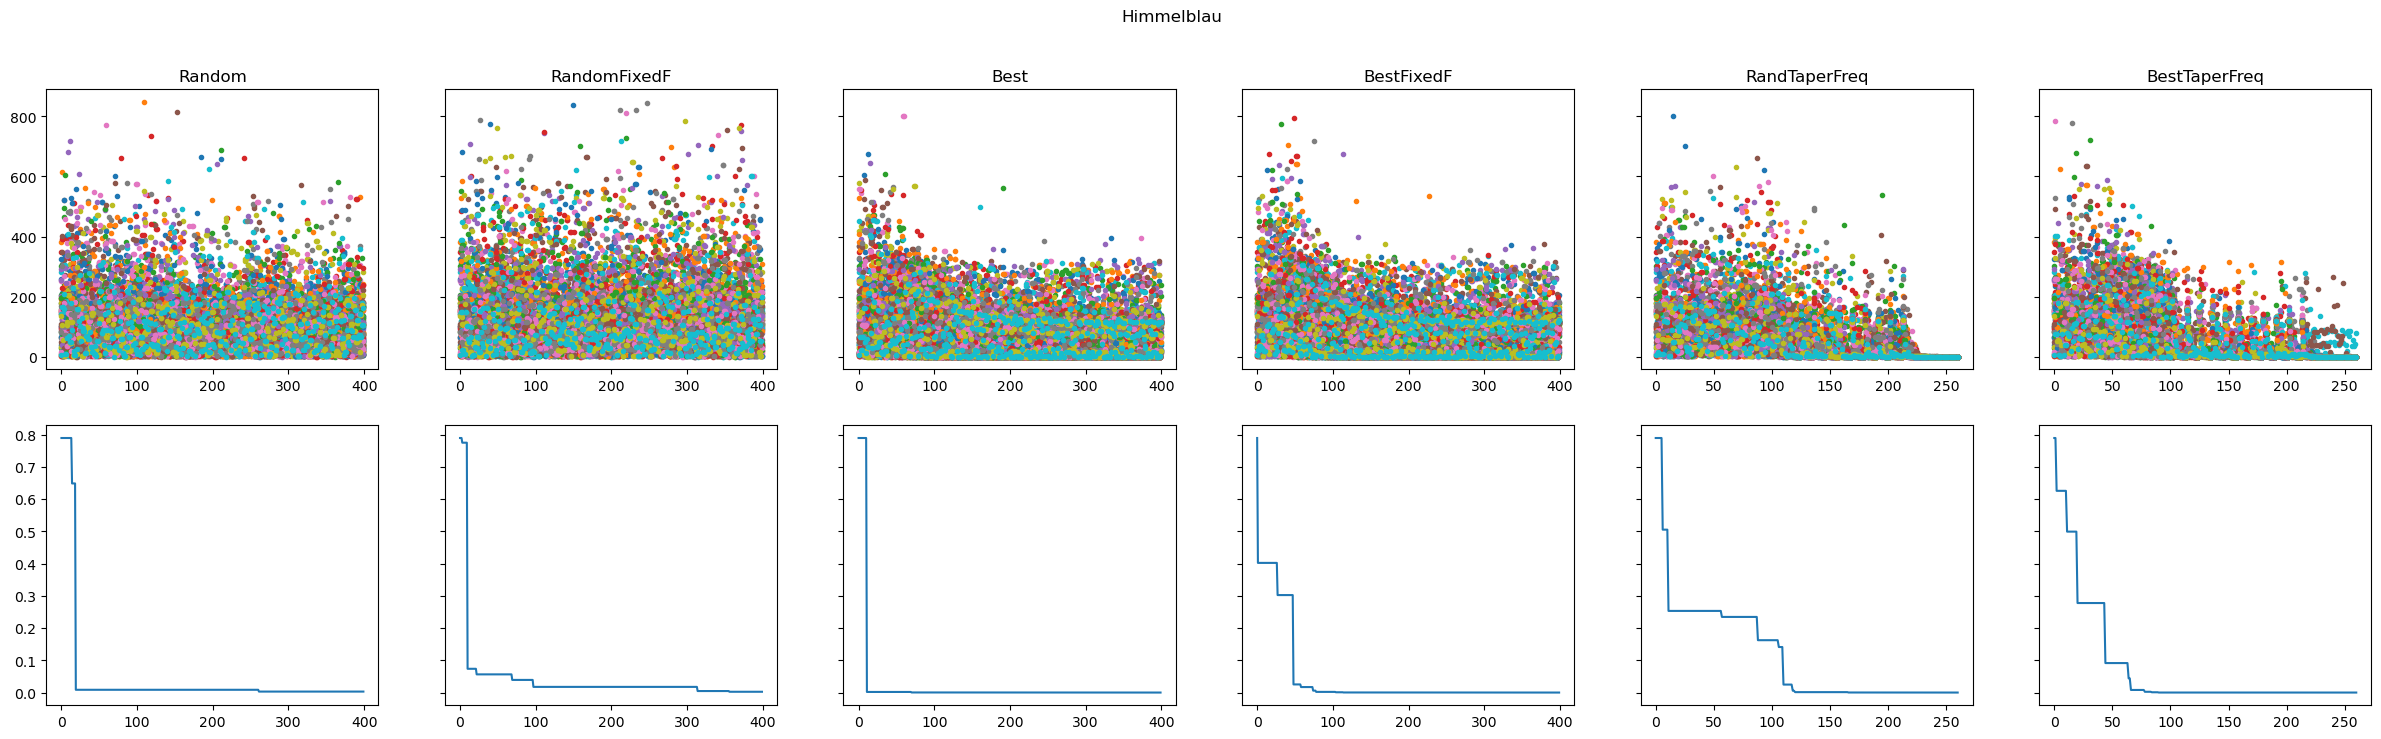

In [8]:
plot_swarm_w_loss(opts, configs, 'Himmelblau')

In [9]:
%%capture
for i, opt in opts.items():
    animation2D = plot_contour(pos_history=opts[i].record_value['X'], mesher=m, designer=d, mark=global_opt)
    animation2D.save('himmelblau_'+str(i)+'.gif', writer='ffmpeg', fps=20)

2025-10-23 00:05:37,096 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:05:37,097 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_Random.gif
2025-10-23 00:06:44,144 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:06:44,145 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_RandomFixedF.gif
2025-10-23 00:07:48,345 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:07:48,346 - matplotlib.animation - INFO - Movie

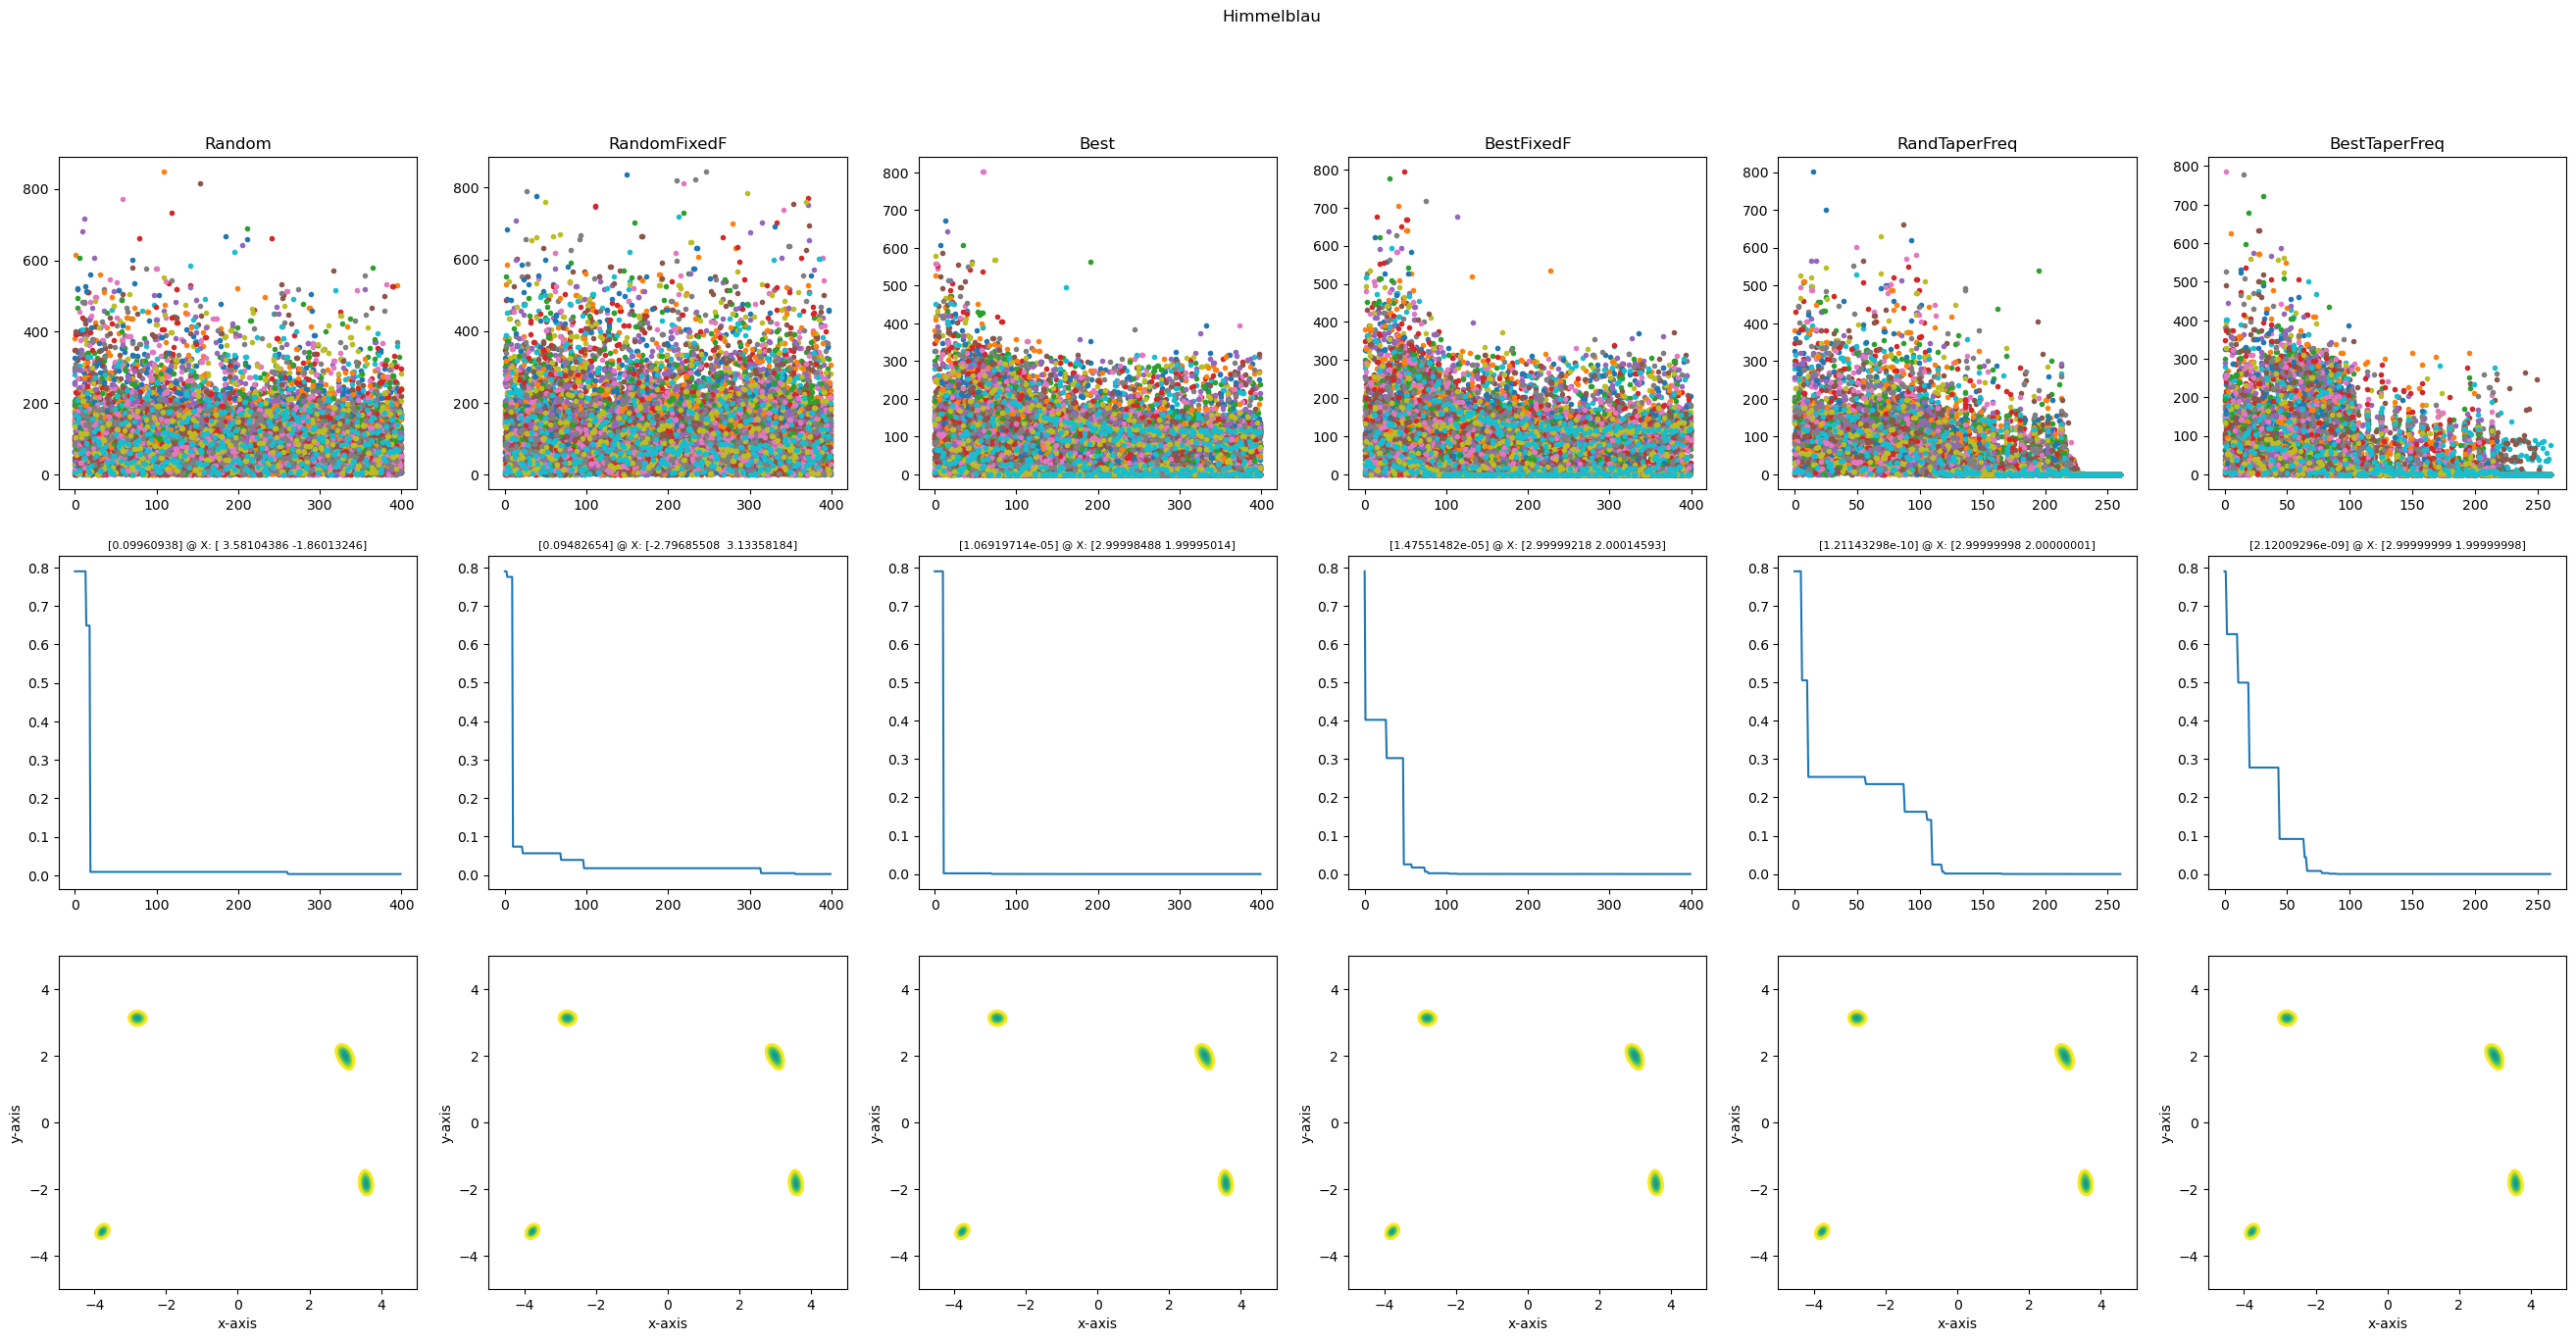

In [10]:
d.figsize= (len(configs) * 5.5, 15)
ani_summary = plot_summary(optimizers=list(opts.values()), title="Himmelblau", titles=[config['name'] for config in configs], mesher=m, designer=d, mark=global_opt)
plt.show()


In [11]:
ani_summary.save('himmelblau_summary.gif', writer='ffmpeg', fps=15)
Image(url='himmelblau_summary.gif')

2025-10-23 00:14:35,970 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:14:35,971 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_summary.gif


In [12]:
%%capture
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Himmelblau", mark=global_opt)
    animation3d.save('himmelblau_'+i+'_3d.gif', writer='ffmpeg', fps=15)
    print(i)

2025-10-23 00:20:14,208 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:20:14,209 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_Random_3d.gif
2025-10-23 00:24:03,462 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:24:03,463 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_RandomFixedF_3d.gif
2025-10-23 00:27:53,424 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:27:53,425 - matplotlib.animation - INFO

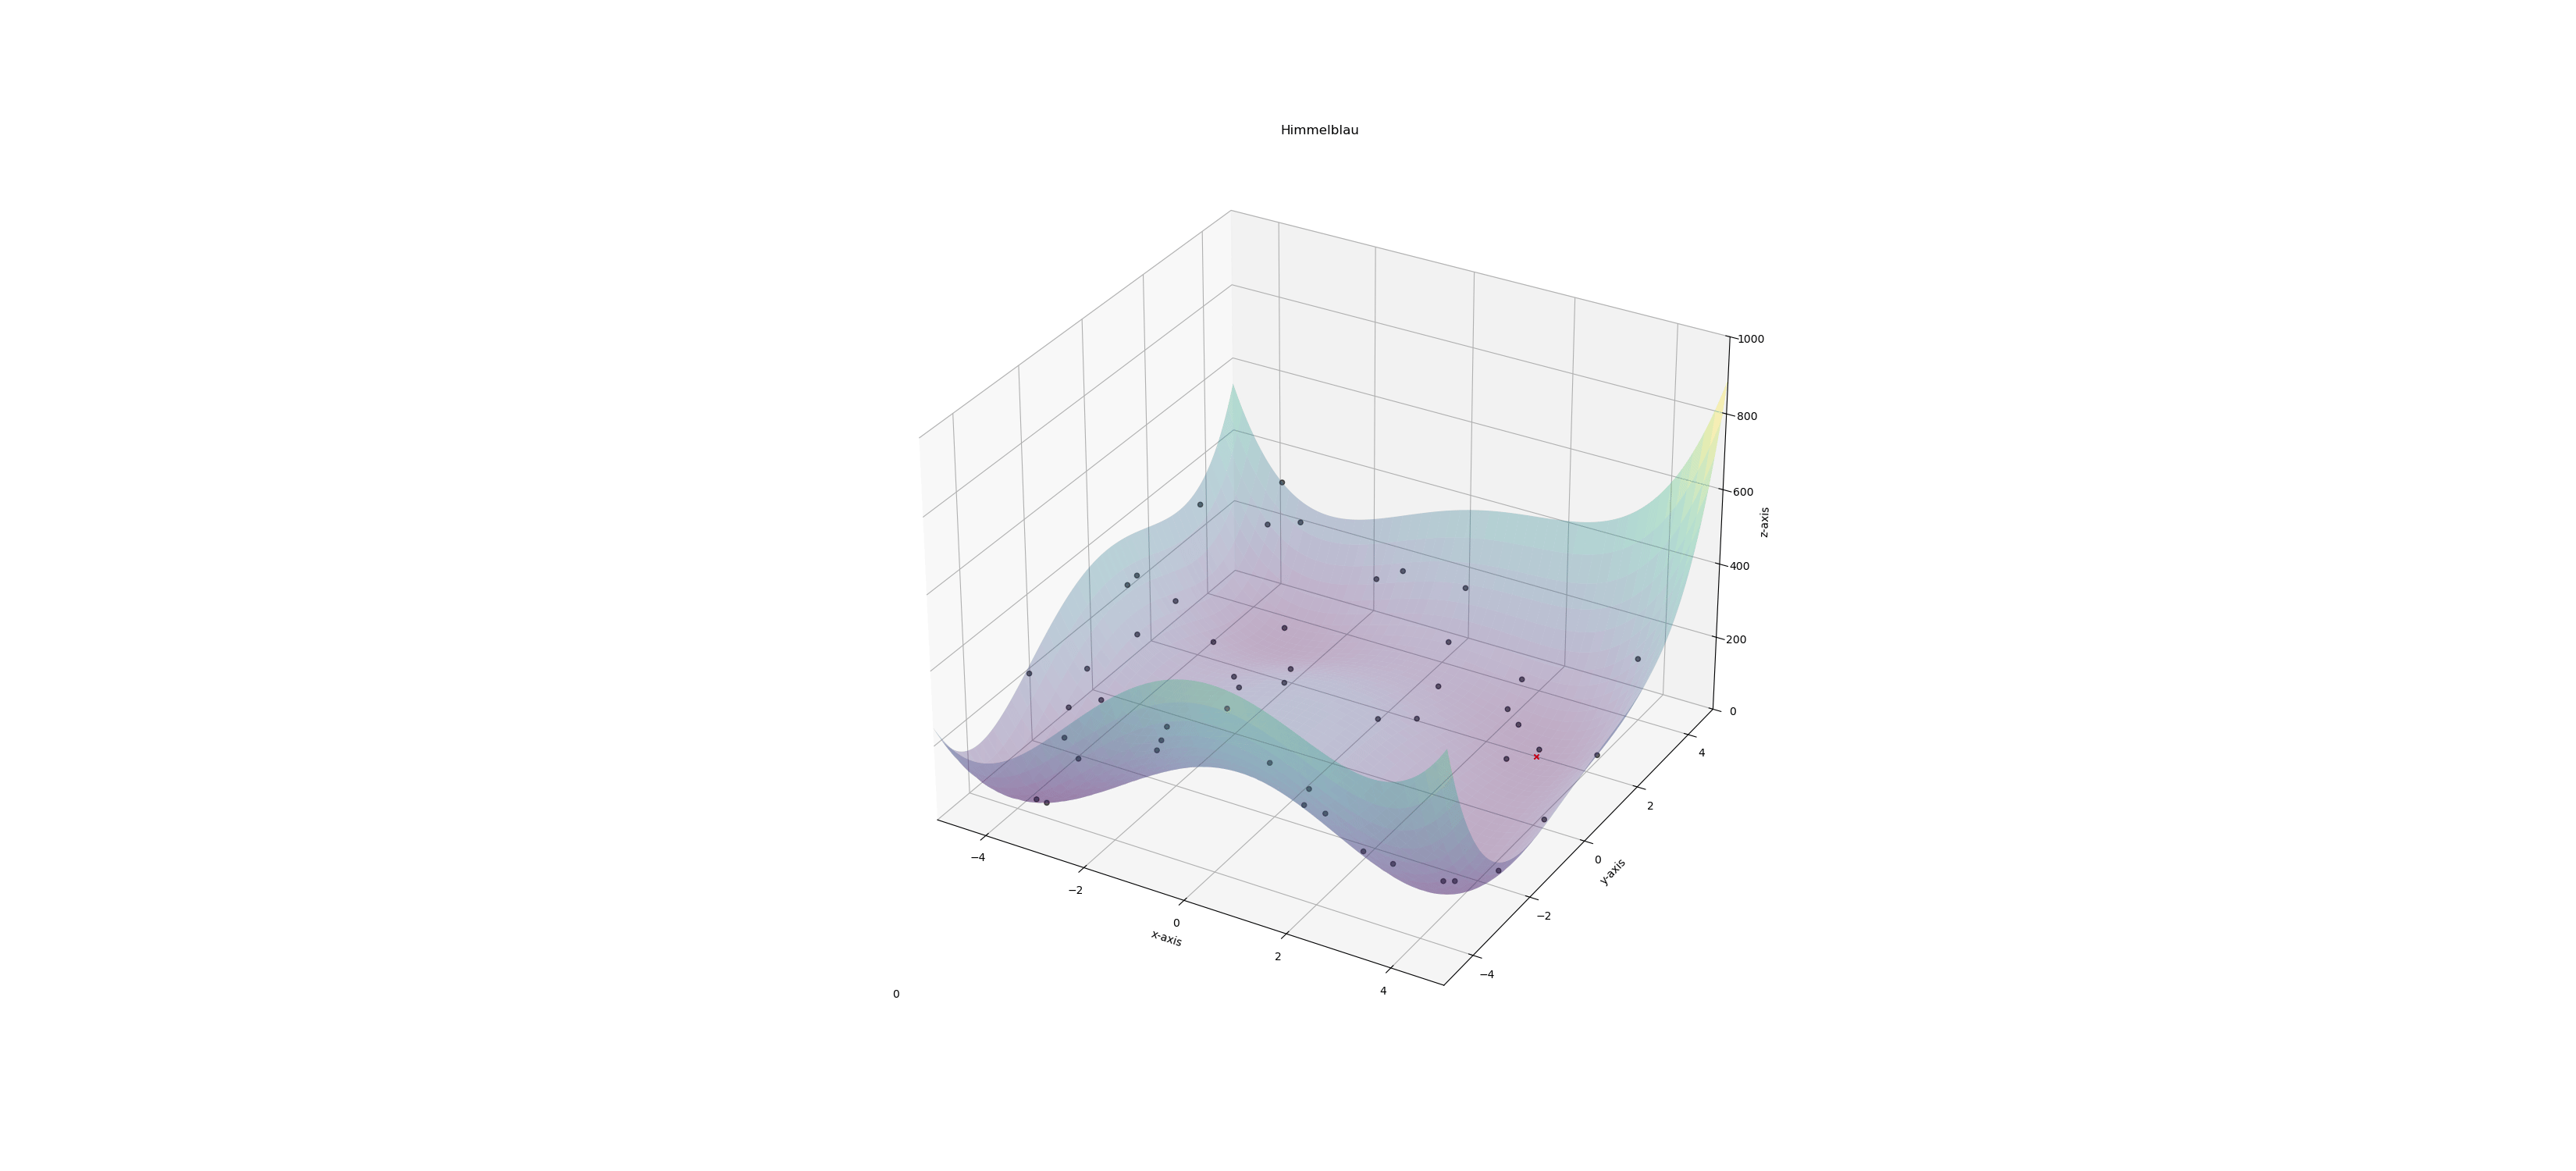

In [13]:
Image('himmelblau_Random_3d.gif')

In [14]:
%%capture
d.limits = [(-5,5), (-5,5), (-0.1, 100.0)]
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Himmelblau", mark=global_opt)
    animation3d.save('himmelblau_zoom_'+i+'_3d.gif', writer='ffmpeg', fps=15)

2025-10-23 00:40:46,847 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:40:46,848 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_zoom_Random_3d.gif
2025-10-23 00:44:39,668 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:44:39,669 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y himmelblau_zoom_RandomFixedF_3d.gif
2025-10-23 00:48:34,610 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 00:48:34,611 - matplotlib.animat

Three-Hump Camel  objective function

    Only takes two dimensions and has a global minimum of `0` at
    :code:`f([0, 0])`. Its coordinates are bounded within
    :code:`[-5, 5]`.

    Best visualized in the full domin and a range of :code:`[0, 2000]`.

In [15]:
import copy
n_dim = 2
lb = [-5., -5.]
ub = [5., 5.]
size_pop = 50
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

global_opt = (0, 0, 0)

In [16]:
#Plot the sphere function's mesh for better plots
m = Mesher(func=example_funcs.threehump, limits=[(-5,5), (-5,5)])
#Adjust figure limits
d = Designer(limits=[(-5,5), (-5,5), (0,2000)], label=['x-axis', 'y-axis', 'z-axis'])

In [17]:
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

for config in configs:
    config["initial_guesses"] = common_start
    config["lb"] = lb
    config["ub"] = ub
    config["n_dim"] = n_dim
    config["vectorize_func"] = False


i: best_x is  [-7.91610784e-31  7.79717259e-31] best_y is [1.24402168e-60]
i: best_x is  [ 9.14871133e-32 -2.92487268e-29] best_y is [8.52828879e-58]
i: best_x is  [-2.20635283e-99  1.09440547e-98] best_y is [1.05361873e-196]
i: best_x is  [-9.93100427e-96  4.56785356e-95] best_y is [1.83014457e-189]
i: best_x is  [3.78772239e-23 9.09925023e-23] best_y is [1.4595547e-44]
i: best_x is  [-1.69214097e-37 -2.04392392e-37] best_y is [1.33629146e-73]


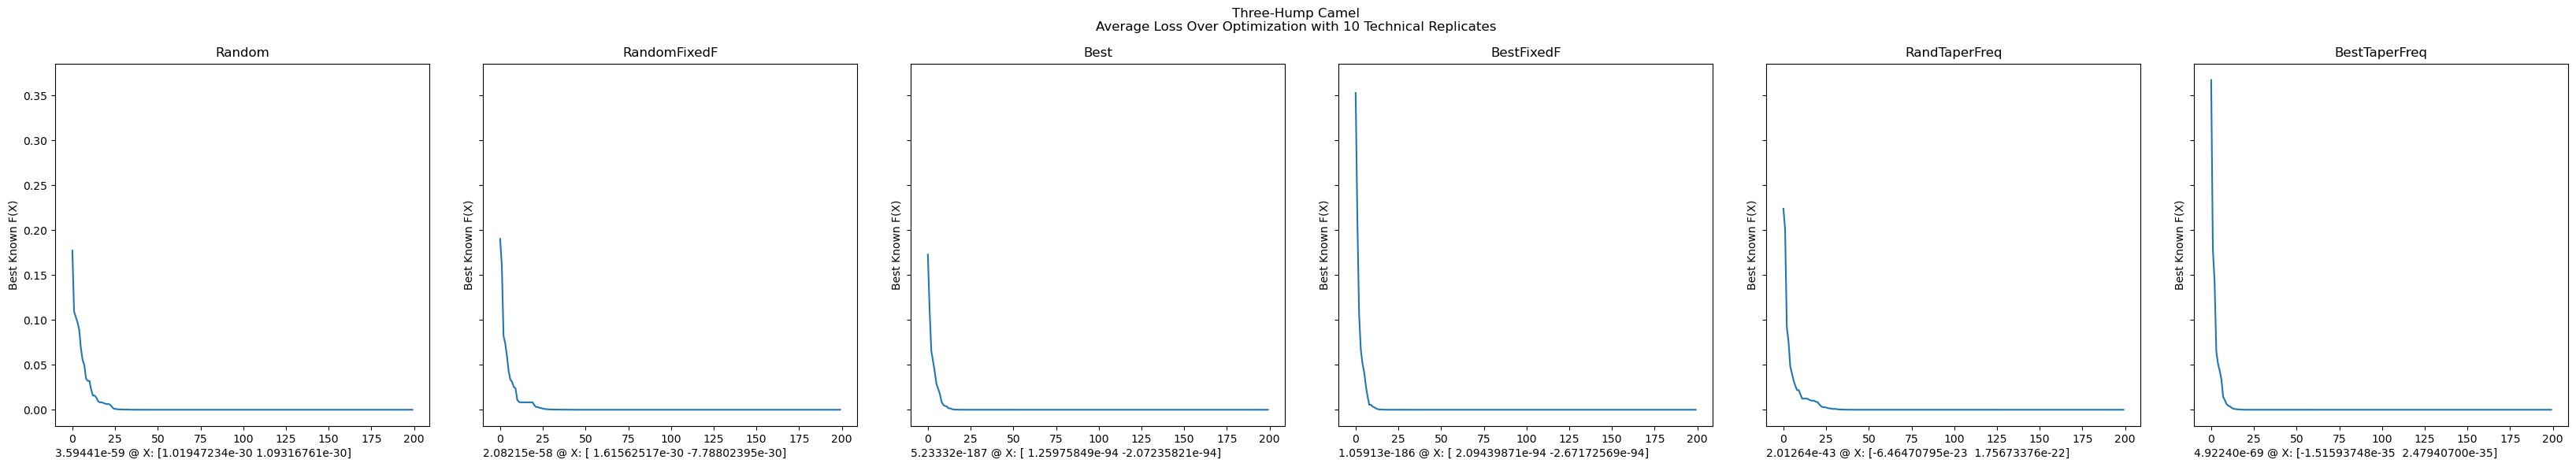

In [18]:
opts, full_opts = run_plot_opts(example_funcs.threehump, n_dim, configs, technical_replicates, 'Three-Hump Camel\nAverage Loss Over Optimization with '+ str(technical_replicates) + ' Technical Replicates')

400
400
400
400
261
261


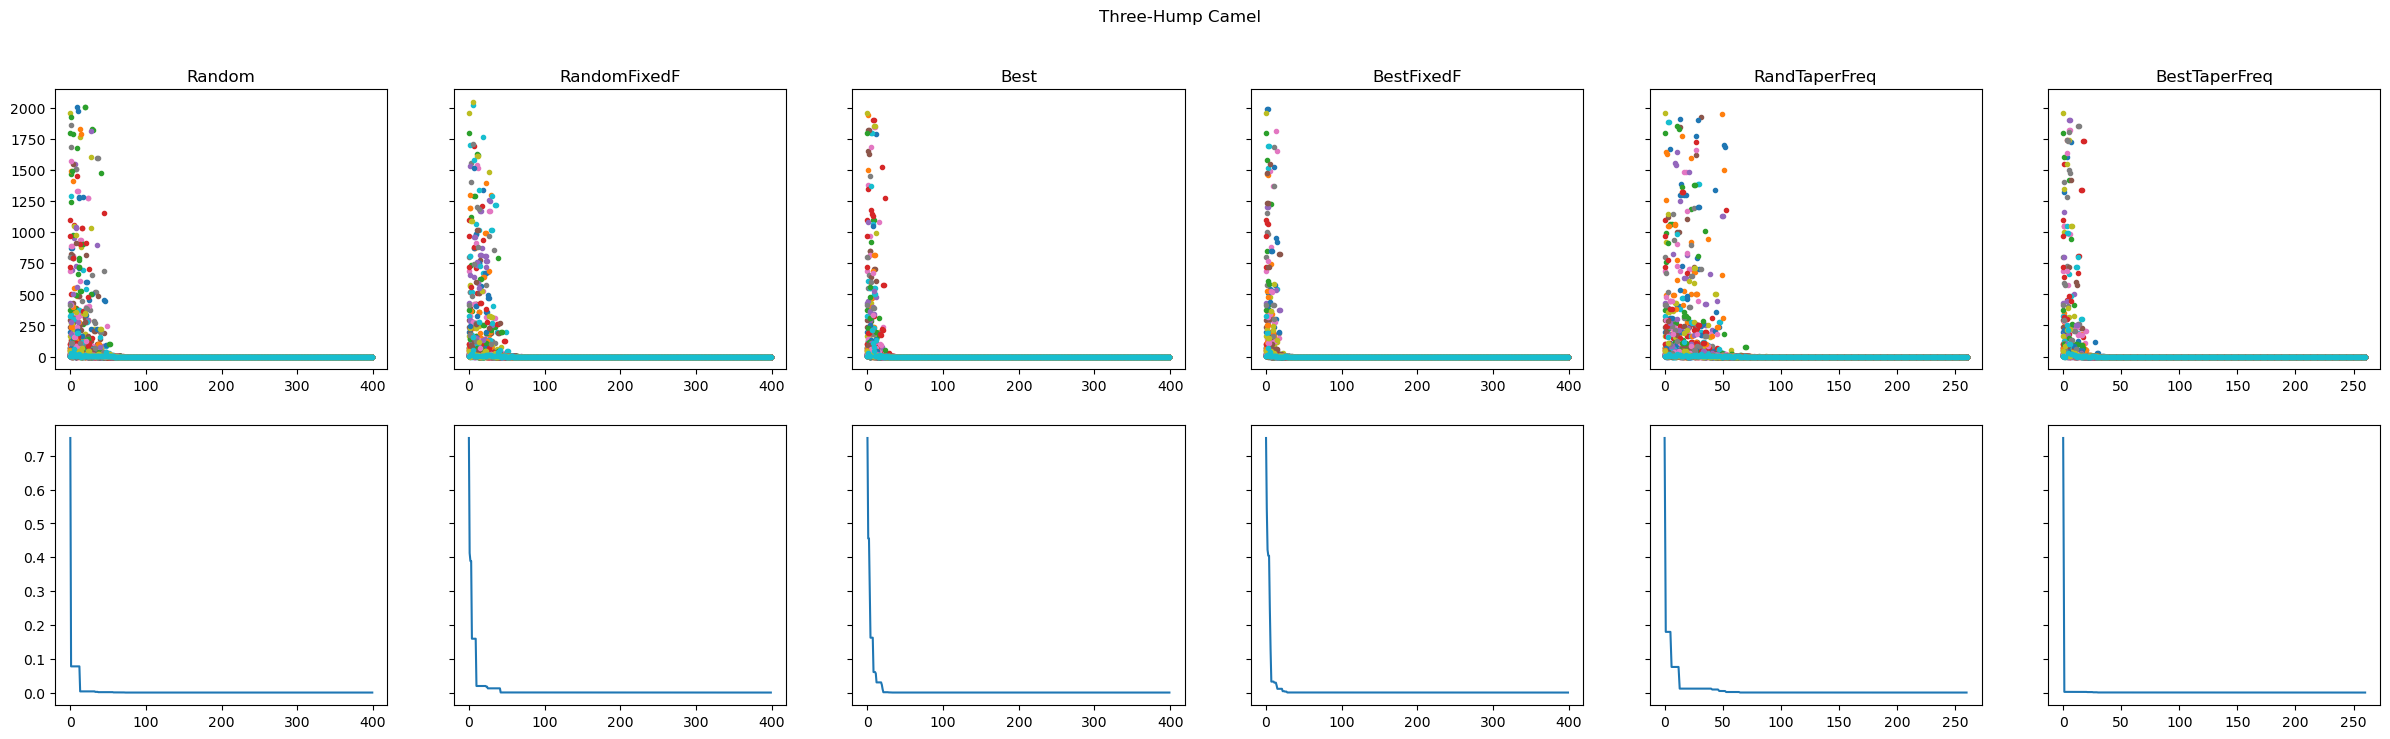

In [19]:
plot_swarm_w_loss(opts, configs, 'Three-Hump Camel')

In [20]:
%%capture
for i, opt in opts.items():
    animation2D = plot_contour(pos_history=opts[i].record_value['X'], mesher=m, designer=d, mark=global_opt)
    animation2D.save('threehump_'+str(i)+'.gif', writer='ffmpeg', fps=20)

2025-10-23 01:02:17,929 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:02:17,930 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_Random.gif
2025-10-23 01:03:47,964 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:03:47,964 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_RandomFixedF.gif
2025-10-23 01:05:17,674 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:05:17,675 - matplotlib.animation - INFO - MovieWr

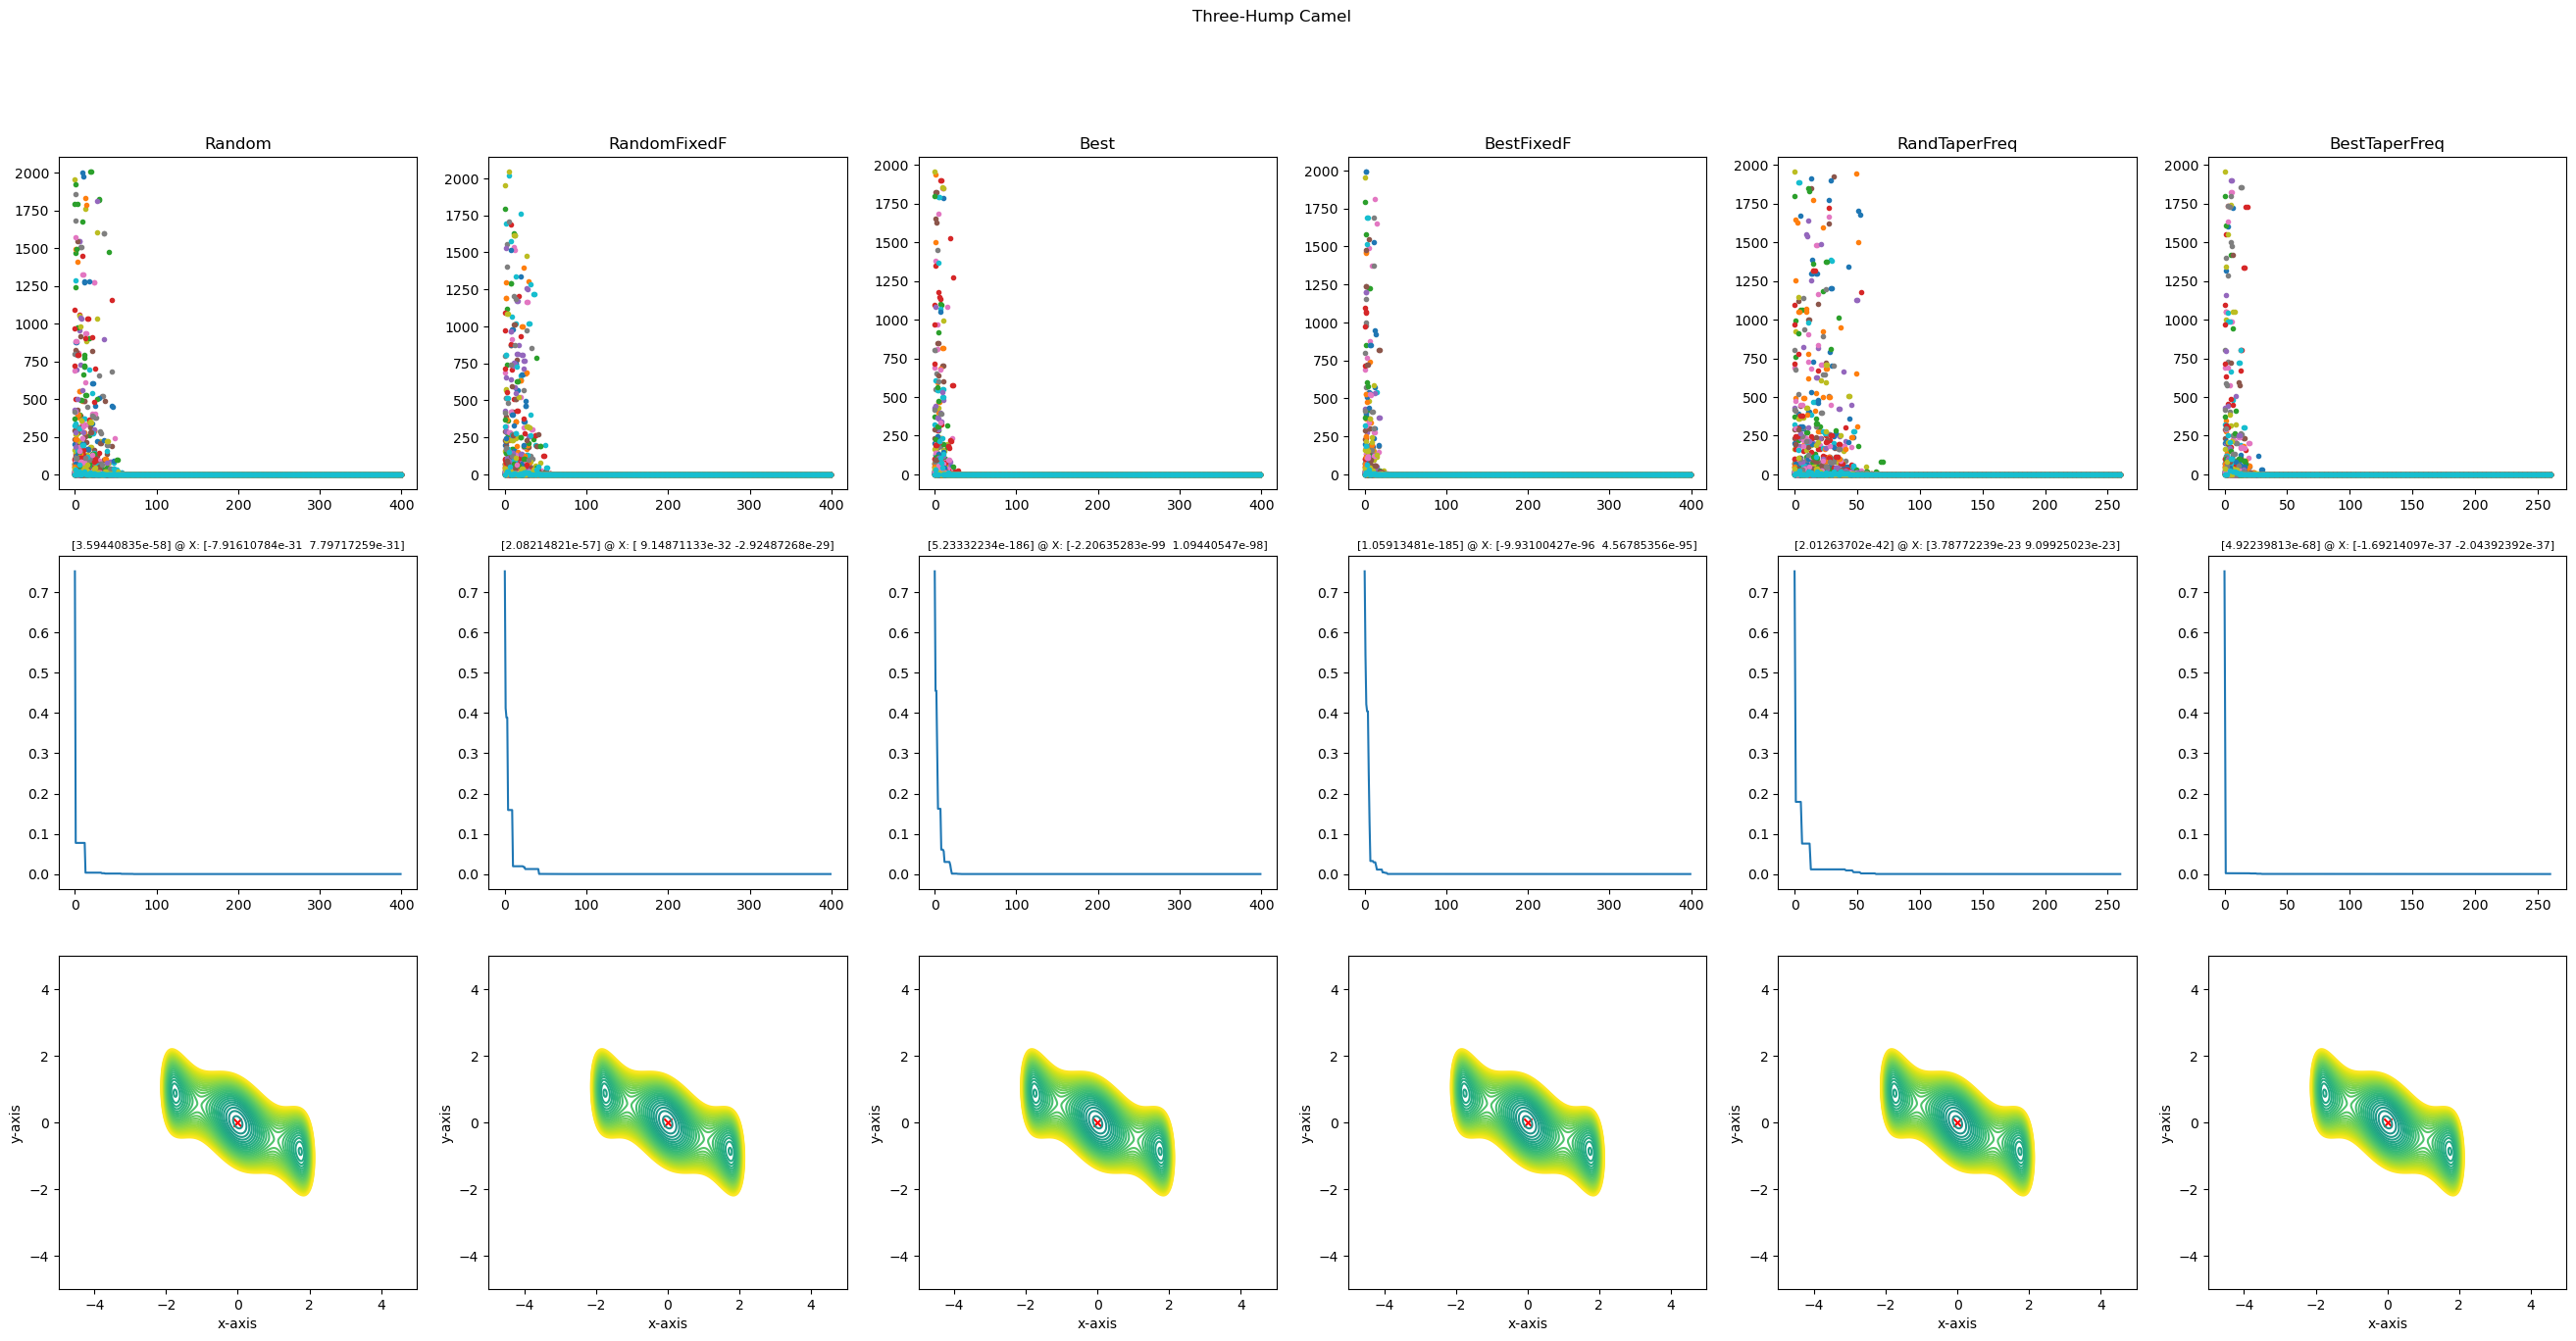

In [21]:
d.figsize= (len(configs) * 5.5, 15)
ani_summary = plot_summary(optimizers=list(opts.values()), title="Three-Hump Camel", titles=[config['name'] for config in configs], mesher=m, designer=d, mark=global_opt)
plt.show()


In [22]:
ani_summary.save('threehump_summary.gif', writer='ffmpeg', fps=15)
Image(url='threehump_summary.gif')

2025-10-23 01:13:41,402 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:13:41,403 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_summary.gif


In [23]:
%%capture
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Three-Hump Camel", mark=global_opt)
    animation3d.save('threehump_'+i+'_3d.gif', writer='ffmpeg', fps=15)
    print(i)

2025-10-23 01:21:35,492 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:21:35,493 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_Random_3d.gif
2025-10-23 01:25:34,894 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:25:34,895 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_RandomFixedF_3d.gif
2025-10-23 01:29:34,577 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:29:34,578 - matplotlib.animation - INFO -

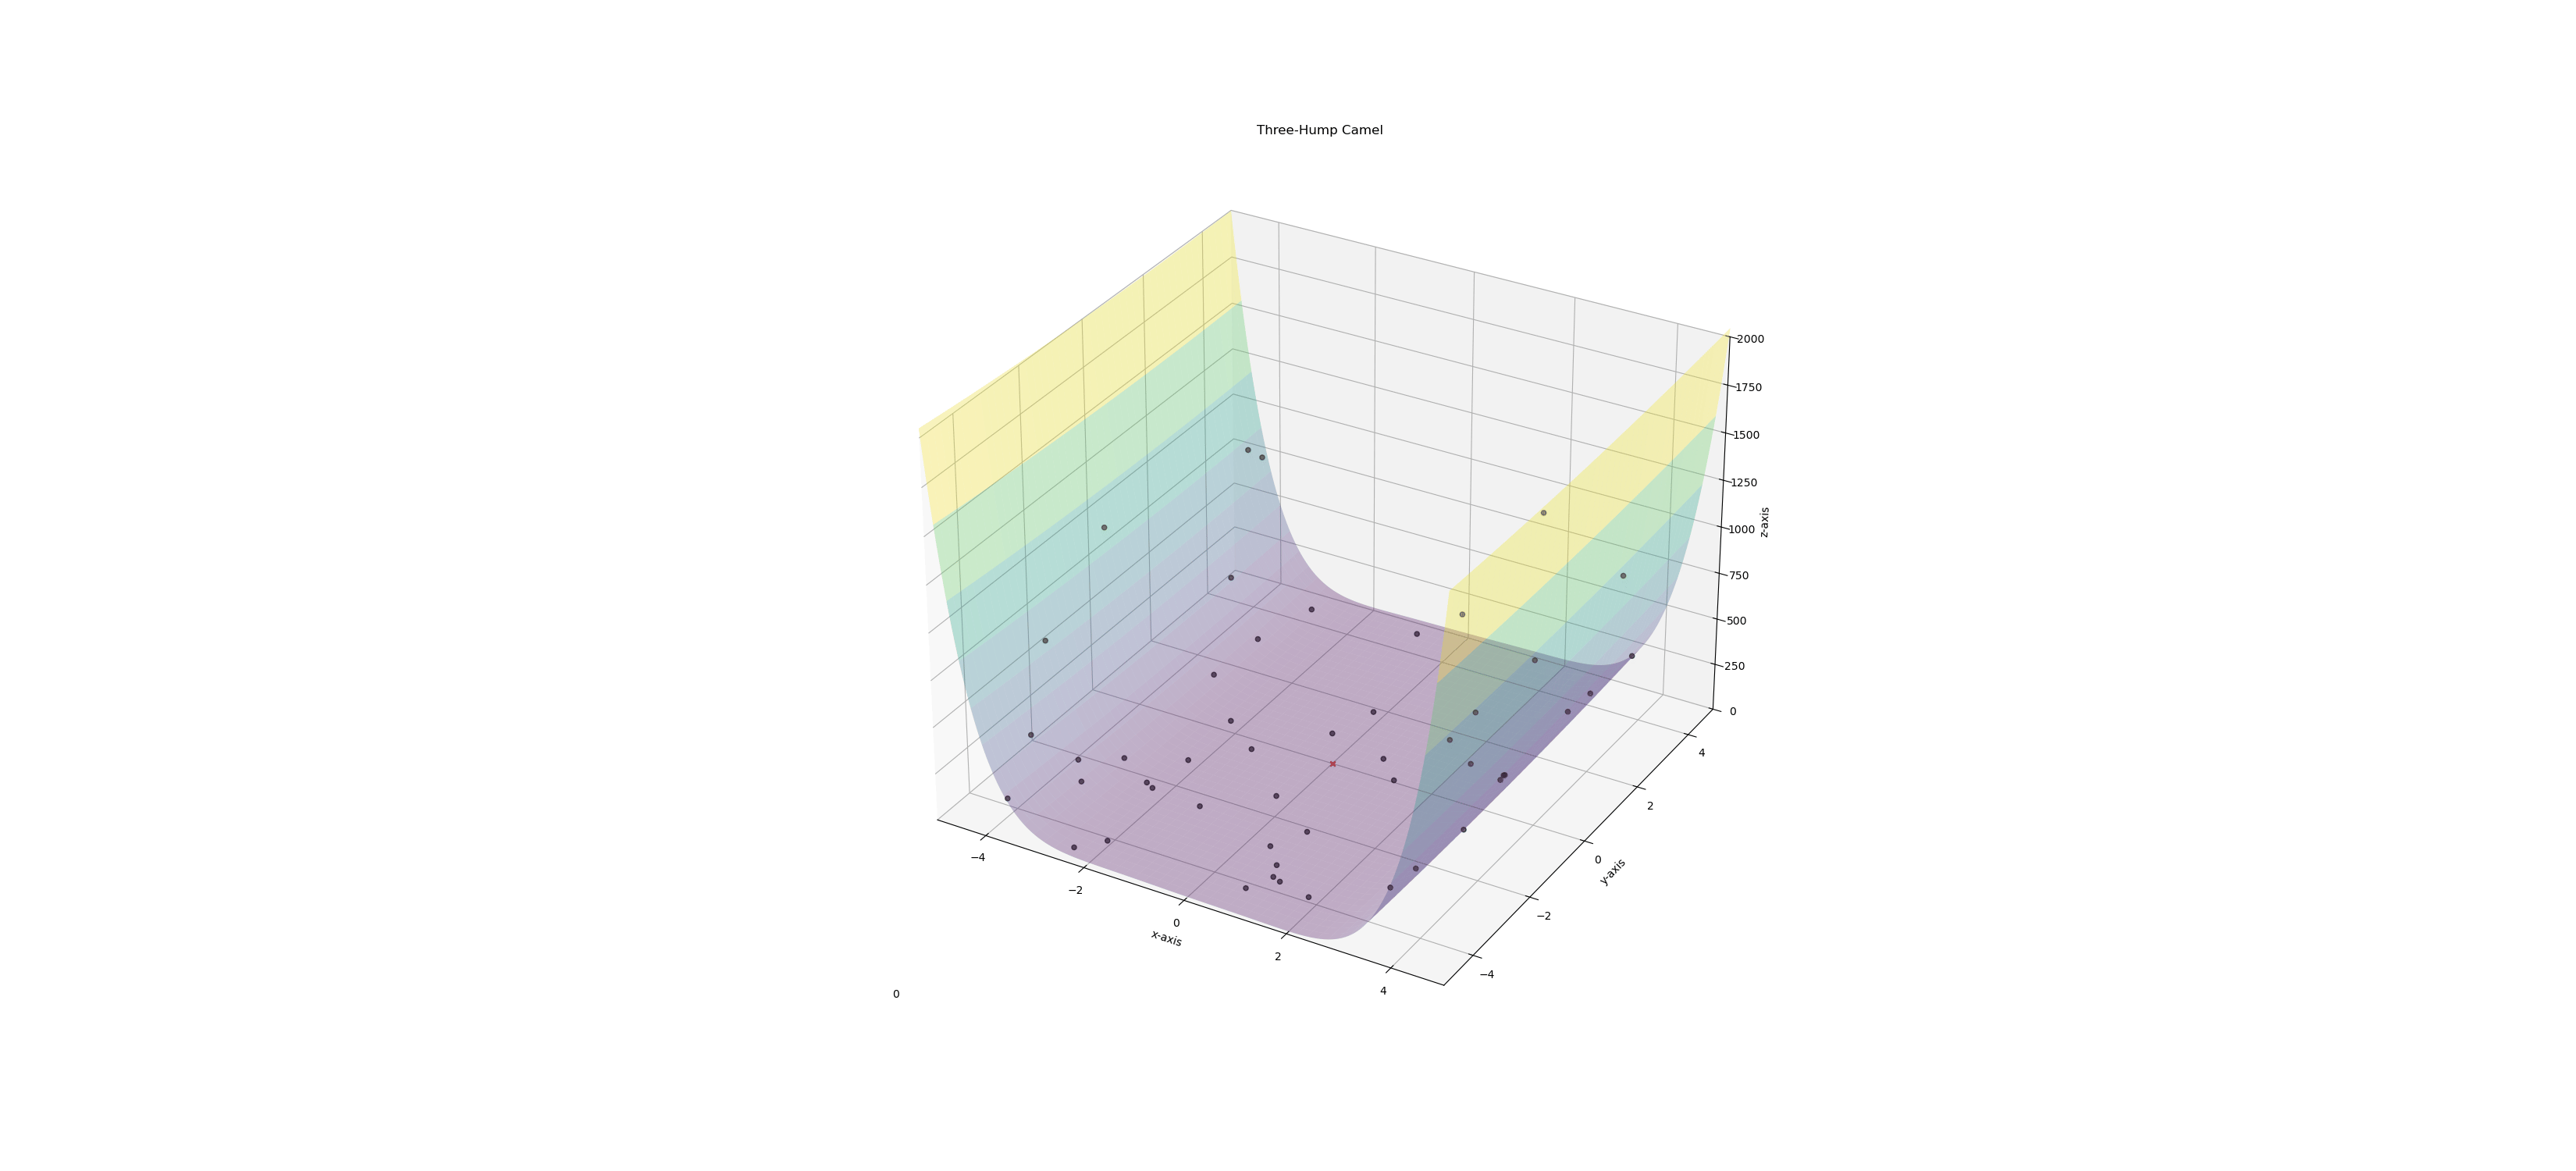

In [24]:
Image('threehump_Random_3d.gif')

In [25]:
%%capture
d.limits = [(-5,5), (-5,5), (-0.1, 100.0)]
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Three-Hump Camel", mark=global_opt)
    animation3d.save('threehump_zoom_'+i+'_3d.gif', writer='ffmpeg', fps=15)

2025-10-23 01:42:57,973 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:42:57,974 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_zoom_Random_3d.gif
2025-10-23 01:46:54,267 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:46:54,268 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3300x1500 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y threehump_zoom_RandomFixedF_3d.gif
2025-10-23 01:50:49,014 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 01:50:49,016 - matplotlib.animatio

Easom's  objective function

    Only takes two dimensions and has a global minimum of
    `-1` at :code:`f([pi, pi])`.
    Its coordinates are bounded within :code:`[-100,100]`.

    Best visualized in the domain of :code:`[-5, 5]` and a range of :code:`[-1, 0.2]`.

In [26]:
import copy
n_dim = 2
lb = [-100., -100.]
ub = [100., 100.]
size_pop = 50
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

global_opt = (np.pi, np.pi, -1)


In [27]:
#Plot the sphere function's mesh for better plots
m = Mesher(func=example_funcs.easom, limits=[(-5,5), (-5,5)])
#Adjust figure limits
d = Designer(limits=[(-5,5), (-5,5), (-1,0.2)], label=['x-axis', 'y-axis', 'z-axis'])

In [28]:
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

for config in configs:
    config["initial_guesses"] = common_start
    config["lb"] = lb
    config["ub"] = ub
    config["n_dim"] = n_dim
    config["vectorize_func"] = False


i: best_x is  [3.11897702 3.16587921] best_y is [-0.99834936]
i: best_x is  [3.15598921 3.19548812] best_y is [-0.9953422]
i: best_x is  [3.14141473 3.1415228 ] best_y is [-0.99999995]
i: best_x is  [3.14156679 3.14162792] best_y is [-1.]
i: best_x is  [3.14159265 3.14159266] best_y is [-1.]
i: best_x is  [3.14159261 3.14159264] best_y is [-1.]


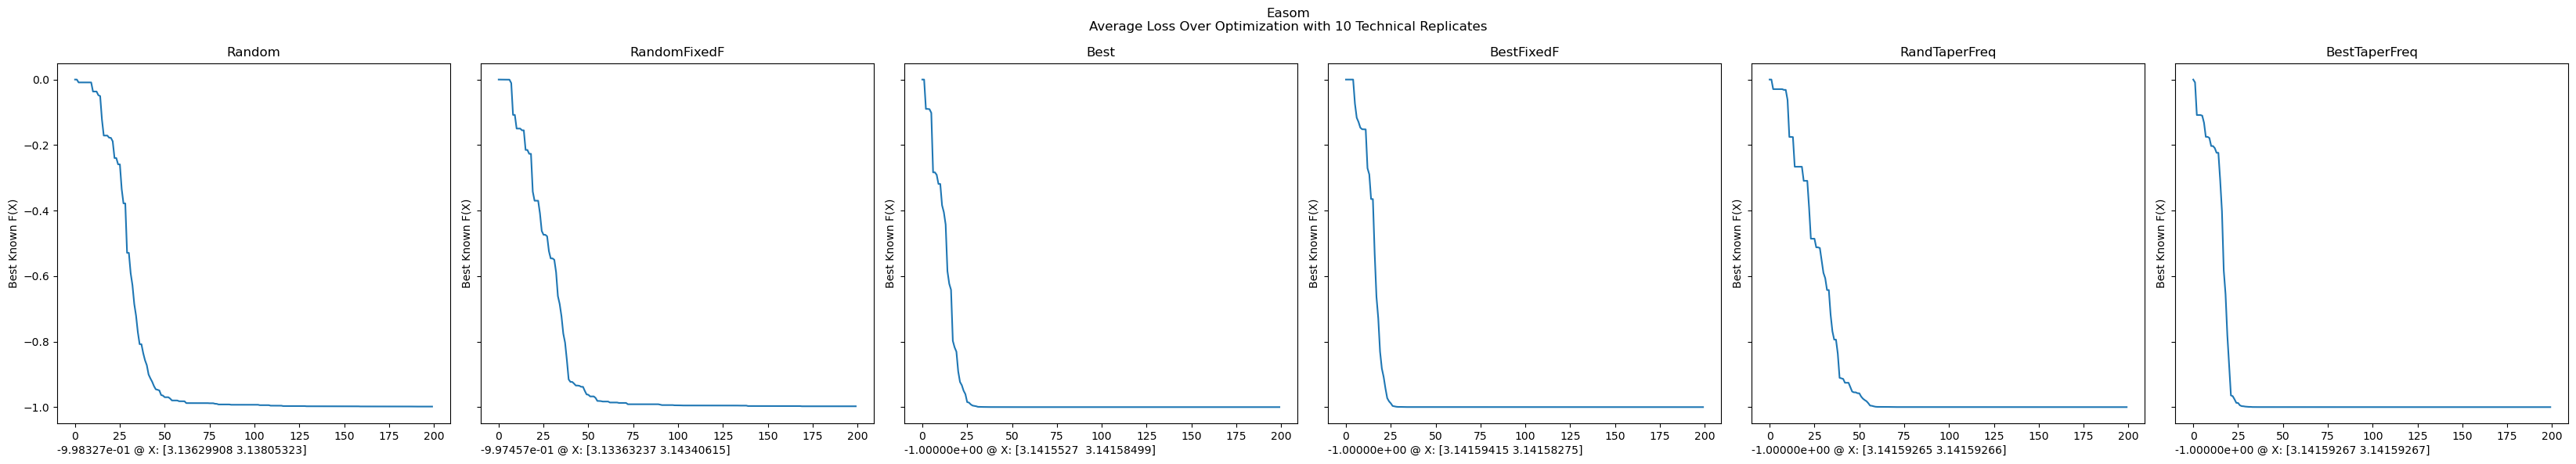

In [29]:
opts, full_opts = run_plot_opts(example_funcs.easom, n_dim, configs, technical_replicates, 'Easom\nAverage Loss Over Optimization with '+ str(technical_replicates) + ' Technical Replicates')

400
400
400
400
261
261


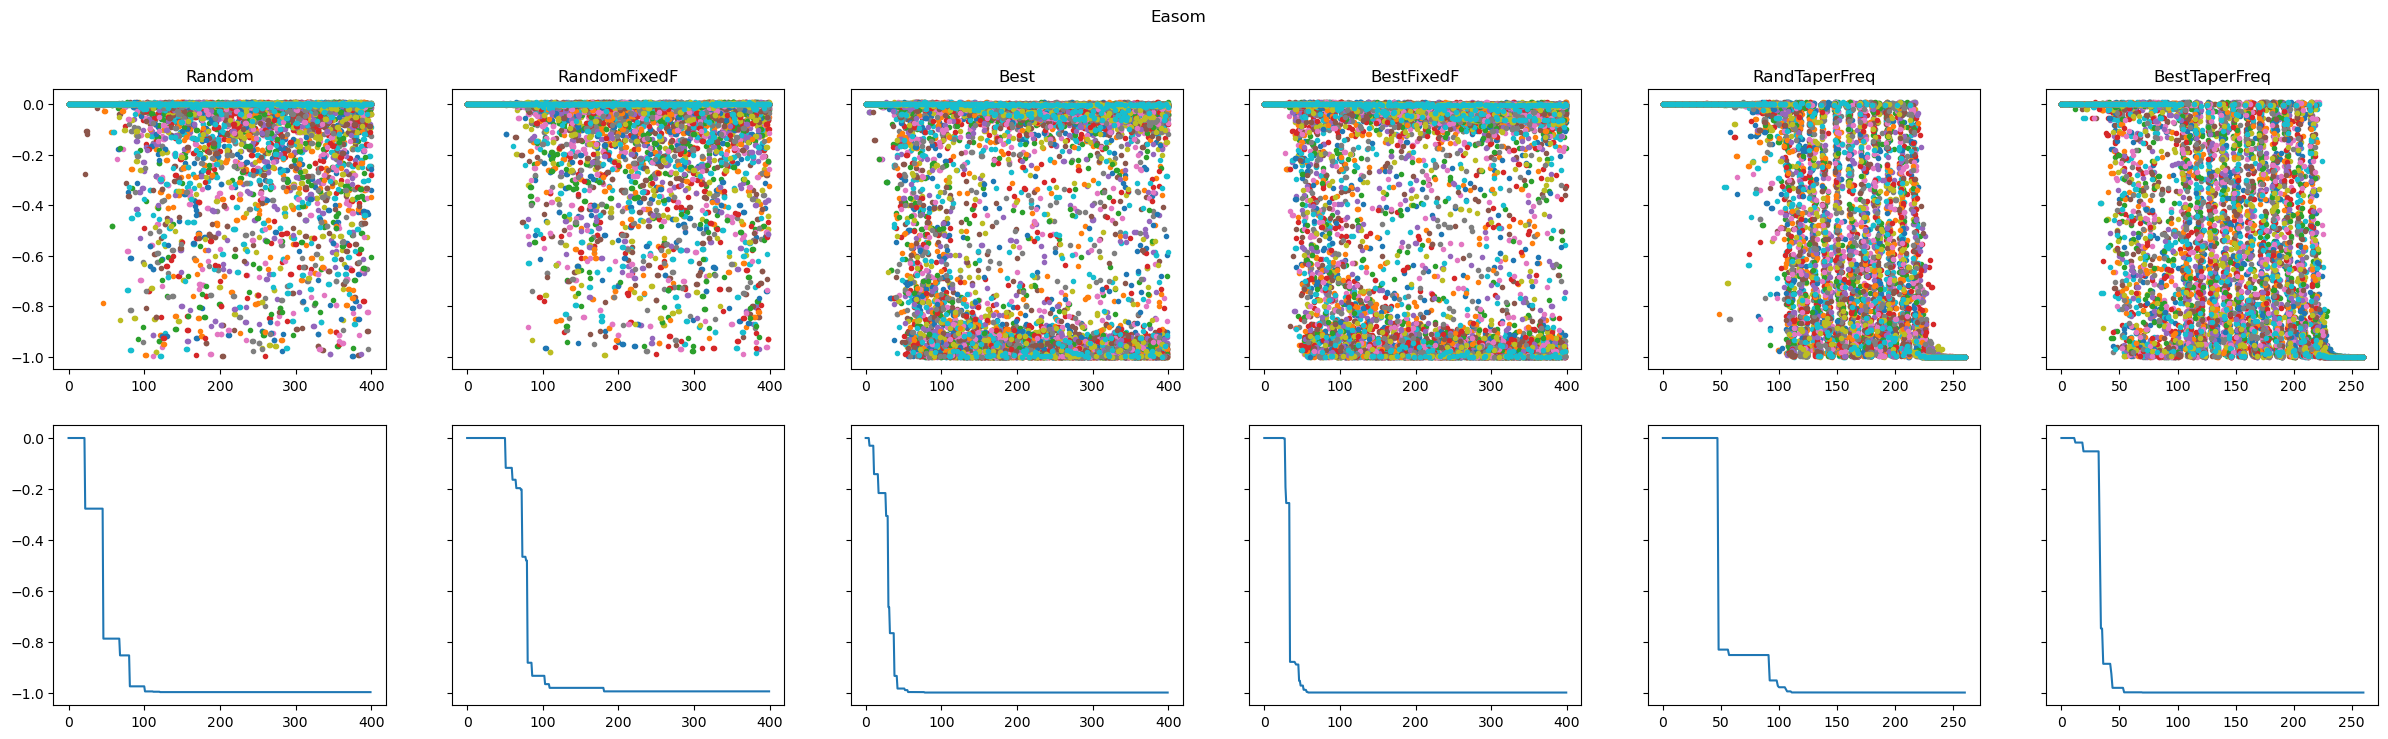

In [30]:
plot_swarm_w_loss(opts, configs, 'Easom')

In [31]:
%%capture
for i, opt in opts.items():
    animation2D = plot_contour(pos_history=opts[i].record_value['X'], mesher=m, designer=d, mark=global_opt)
    animation2D.save('easom_'+str(i)+'.gif', writer='ffmpeg', fps=20)

2025-10-23 02:04:35,534 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 02:04:35,535 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y easom_Random.gif
2025-10-23 02:05:37,575 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 02:05:37,575 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y easom_RandomFixedF.gif
2025-10-23 02:06:37,443 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-23 02:06:37,444 - matplotlib.animation - INFO - MovieWriter._ru

In [ ]:
d.figsize= (len(configs) * 5.5, 15)
ani_summary = plot_summary(optimizers=list(opts.values()), title="Easom", titles=[config['name'] for config in configs], mesher=m, designer=d, mark=global_opt)
plt.show()


In [ ]:
ani_summary.save('easom_summary.gif', writer='ffmpeg', fps=15)
Image(url='easom_summary.gif')

In [ ]:
%%capture
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Easom", mark=global_opt)
    animation3d.save('easom_'+i+'_3d.gif', writer='ffmpeg', fps=15)
    print(i)

In [ ]:
Image('easom_Random_3d.gif')

Styblinski-Tang's  objective function

    -5 to 5 with global minimum of -39.16599*n_dim at (-2.903534,...,-2.903534)'''
    Its coordinates are bounded within :code:`[-5,5]`.

    Best visualized with the full domain and a range of :code:`[-100,250]`

In [ ]:
n_dim = 2
lb = [-5., -5.]
ub = [5., 5.]
size_pop = 50
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))
global_opt=(-2.903534, -2.903534, -39.16599)


In [ ]:
#Plot the sphere function's mesh for better plots
m = Mesher(func=opts['Random'].func, limits=[(-5,5), (-5,5)])
#Adjust figure limits
d = Designer(limits=[(-5,5), (-5,5), (-100,250)], label=['x-axis', 'y-axis', 'z-axis'])

In [ ]:
common_start = np.random.uniform(low=lb, high=ub, size=(size_pop, n_dim))

for config in configs:
    config["initial_guesses"] = common_start
    config["lb"] = lb
    config["ub"] = ub
    config["n_dim"] = n_dim
    config["vectorize_func"] = True


In [ ]:
opts, full_opts = run_plot_opts(example_funcs.styblinski_tang, n_dim, configs, technical_replicates, 'Styblinski-Tang\nAverage Loss Over Optimization with '+ str(technical_replicates) + ' Technical Replicates')

In [ ]:
plot_swarm_w_loss(opts, configs, 'Styblinski-Tang')

In [ ]:
%%capture
for i, opt in opts.items():
    animation2D = plot_contour(pos_history=opts[i].record_value['X'], mesher=m, designer=d, mark=global_opt)
    animation2D.save('styblinski_tang_'+str(i)+'.gif', writer='ffmpeg', fps=20)

In [ ]:
d.figsize= (len(configs) * 5.5, 15)
ani_summary = plot_summary(optimizers=list(opts.values()), title="Styblinski-Tang", titles=[config['name'] for config in configs], mesher=m, designer=d, mark=global_opt)
plt.show()


In [ ]:
ani_summary.save('styblinski_tang_summary.gif', writer='ffmpeg', fps=15)
Image(url='styblinski_tang_summary.gif')

In [ ]:
%%capture
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Styblinski-Tang", mark=global_opt)
    animation3d.save('styblinski_tang_'+i+'_3d.gif', writer='ffmpeg', fps=15)
    print(i)

In [ ]:
Image('styblinski_tang_Random_3d.gif')

In [ ]:
%%capture
d.limits = [(-5,5), (-5,5), (-40.1, 1.0)]
for i, opt in opts.items():
    pos_history_3d = m.compute_history_3d(opts[i].record_value['X']) #preprocessing
    animation3d = plot_surface(pos_history=pos_history_3d, mesher=m, designer=d, title="Styblinski-Tang", mark=global_opt)
    animation3d.save('styblinski_tang_zoom_'+i+'_3d.gif', writer='ffmpeg', fps=15)